In [40]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [41]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: CE66-DCE3

 C:\Users\AFFINITY 디렉터리

2019-10-28  오후 01:14    <DIR>          .
2019-10-28  오후 01:14    <DIR>          ..
2019-10-14  오후 03:21    <DIR>          .anaconda
2019-10-22  오후 03:25    <DIR>          .conda
2019-10-22  오전 10:53                43 .condarc
2019-10-14  오후 03:48               174 .gitconfig
2019-10-18  오전 09:55    <DIR>          .ipynb_checkpoints
2019-10-14  오후 04:48    <DIR>          .ipython
2019-10-16  오전 09:22    <DIR>          .jupyter
2019-10-16  오전 09:24    <DIR>          .keras
2019-10-14  오후 05:01    <DIR>          .matplotlib
2019-10-14  오후 05:49                91 .python_history
2019-10-07  오전 09:23    <DIR>          3D Objects
2019-10-14  오후 02:58    <DIR>          Anaconda3
2019-10-17  오후 02:01    <DIR>          ansel
2019-10-24  오후 03:31    <DIR>          bestfeature
2019-10-07  오전 09:23    <DIR>          Contacts
2019-10-22  오전 11:08    <DIR>          data
2019-10-14  오후 04:03       218,854,974 data.zip
2019-10-22  

2019-10-28  오후 01:08        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_0.3516.h5
2019-10-28  오후 01:07        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_0.4827.h5
2019-10-28  오후 01:07        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_0.5441.h5
2019-10-28  오전 10:26        38,958,176 창문-창문을 가린 커튼_mobile_model_0.90_0.5485.h5
2019-10-28  오전 10:56        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_0.6965.h5
2019-10-28  오후 01:07        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_0.7321.h5
2019-10-28  오후 01:07        38,958,632 창문-창문을 가린 커튼_mobile_model_0.90_1.0504.h5
2019-10-28  오전 10:57        38,958,632 크기-사람-작다_mobile_model_0.12_10.1764.h5
2019-10-28  오후 01:09        38,958,632 크기-사람-작다_mobile_model_0.12_13.1362.h5
2019-10-28  오후 01:09        38,958,632 크기-사람-작다_mobile_model_0.56_1.9103.h5
2019-10-28  오전 10:58        38,958,632 크기-사람-작다_mobile_model_0.83_0.3943.h5
2019-10-28  오전 10:58        38,958,632 크기-사람-작다_mobile_model_0.90_0.2081.h5
2019-10-28  오후 01:09        38,958,632 크기-사람-작다_mobile_mod

In [42]:
DATA_PATH = 'C:/Users/AFFINITY/data/splitlabel/'
IMAGE_PATH = 'C:/Users/AFFINITY/data/467case_cut-20190916T015832Z-001/'
os.listdir(DATA_PATH)

['sub_다리-넓게 벌림.xlsx',
 'sub_다리-앉아있음.xlsx',
 'sub_머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 'sub_문-격자무늬 창.xlsx',
 'sub_발-발가락 그림.xlsx',
 'sub_손-부재.xlsx',
 'sub_손-원모양 손, 주먹쥔 손.xlsx',
 'sub_손-정교함(손톱, 주름).xlsx',
 'sub_손-크다.xlsx',
 'sub_위치-사람-오른쪽.xlsx',
 'sub_위치-사람-정중앙.xlsx',
 'sub_위치-집-아래.xlsx',
 'sub_위치-집-정중앙.xlsx',
 'sub_음영-사람-그림자.xlsx',
 'sub_음영-사람-내부의 진한 음영.xlsx',
 'sub_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'sub_지붕-그물무늬 음영.xlsx',
 'sub_창문-격자무늬.xlsx',
 'sub_창문-많다.xlsx',
 'sub_창문-창문을 가린 커튼.xlsx',
 'sub_코-작다.xlsx',
 'sub_크기-사람-작다.xlsx',
 'sub_팔-길다.xlsx',
 'test_다리-넓게 벌림.xlsx',
 'test_다리-앉아있음.xlsx',
 'test_머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 'test_문-격자무늬 창.xlsx',
 'test_발-발가락 그림.xlsx',
 'test_손-부재.xlsx',
 'test_손-원모양 손, 주먹쥔 손.xlsx',
 'test_손-정교함(손톱, 주름).xlsx',
 'test_손-크다.xlsx',
 'test_위치-사람-오른쪽.xlsx',
 'test_위치-사람-정중앙.xlsx',
 'test_위치-집-아래.xlsx',
 'test_위치-집-정중앙.xlsx',
 'test_음영-사람-그림자.xlsx',
 'test_음영-사람-내부의 진한 음영.xlsx',
 'test_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'test_지붕-그물무늬 음영.xlsx',
 'test_창문-격자무늬.xlsx',
 'test_창문

In [120]:
feature = ['문-격자무늬 창',
         '위치-집-아래',
         '위치-집-정중앙',
         '지면선-벽 밑면 있지만 지면 없음',
         '지붕-그물무늬 음영',
         '창문-격자무늬',
         '창문-많다',
         '창문-창문을 가린 커튼',
        "크기-사람-작다",
        "위치-사람-정중앙",
        "위치-사람-오른쪽",
        "음영-사람-내부의 진한 음영",
        "코-작다",
        "머리카락-윤곽선(검게 표현되지 않은 긴 머리)",
        "팔-길다",
        "손-원모양 손, 주먹쥔 손",
        "다리-넓게 벌림",
        "다리-앉아있음",
        "발-발가락 그림"]

In [121]:
IMG_PATH = os.path.join(IMAGE_PATH,'house')

df_train = []
df_test = []
for excel_name in feature:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH,'train_' + excel_name + '.xlsx')))
    df_train[feature.index(excel_name)]['data'] = df_train[feature.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH,'test_' + excel_name + '.xlsx')))
    df_test[feature.index(excel_name)]['data'] = df_test[feature.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [122]:
for i in range(len(feature)):
    print(df_train[i].head(5))
    print(df_test[i].head(5))

   Unnamed: 0        data  문-격자무늬 창
0         127  0237_H.jpg         0
1         169  0318_H.jpg         0
2          48  0080_H.jpg         0
3         216  0417_H.jpg         0
4         268  0495_H.jpg         0
   Unnamed: 0        data  문-격자무늬 창
0          60  0104_H.jpg         0
1         271  0498_H.jpg         0
2          22  0038_H.jpg         0
3         102  0196_H.jpg         0
4         109  0203_H.jpg         0
   Unnamed: 0        data  위치-집-아래
0           2  0004_H.jpg        0
1         186  0356_H.jpg        0
2         124  0234_H.jpg        0
3         103  0197_H.jpg        1
4          53  0091_H.jpg        0
   Unnamed: 0        data  위치-집-아래
0         233  0444_H.jpg        0
1          14  0023_H.jpg        0
2         152  0287_H.jpg        1
3          43  0073_H.jpg        1
4          28  0046_H.jpg        1
   Unnamed: 0        data  위치-집-정중앙
0         206  0397_H.jpg         0
1         153  0288_H.jpg         0
2         160  0301_H.jpg         0
3   

4         121  0216_P.jpg         0
   Unnamed: 0        data  발-발가락 그림
0         244  0461_P.jpg         0
1          84  0143_P.jpg         0
2          92  0163_P.jpg         0
3         128  0232_P.jpg         0
4          85  0144_P.jpg         0


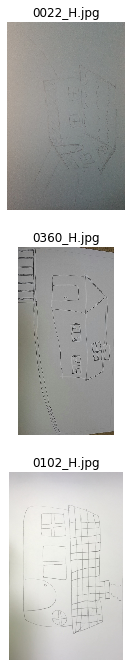

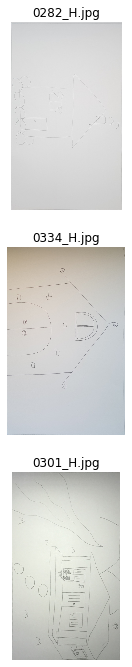

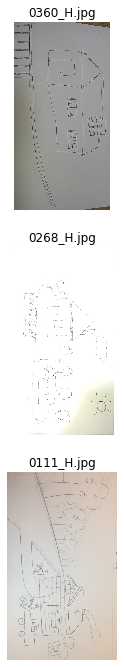

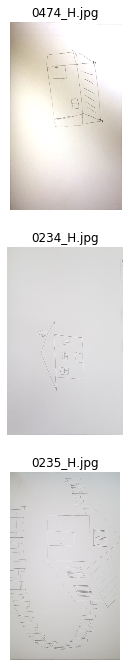

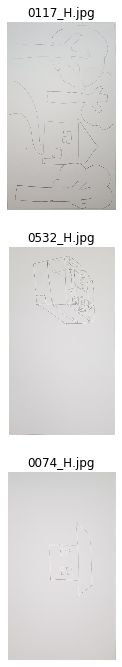

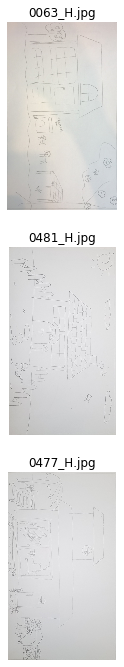

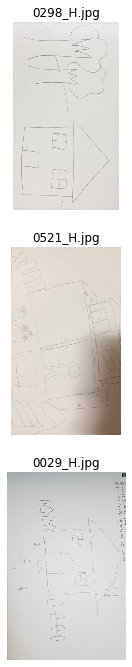

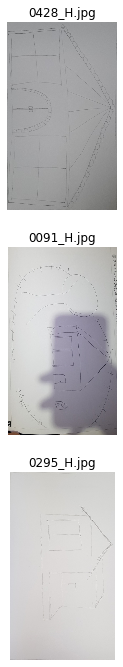

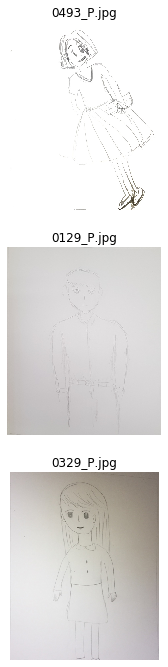

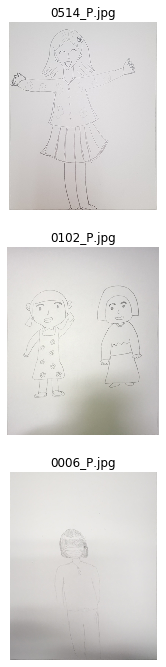

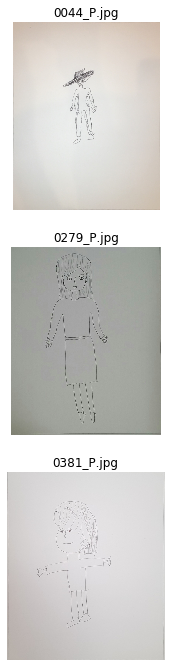

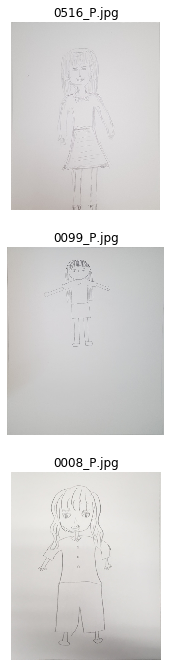

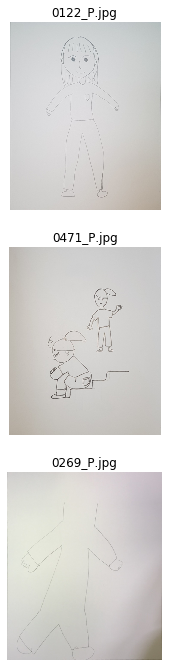

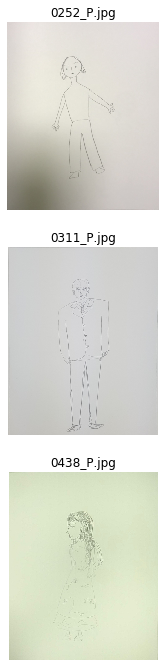

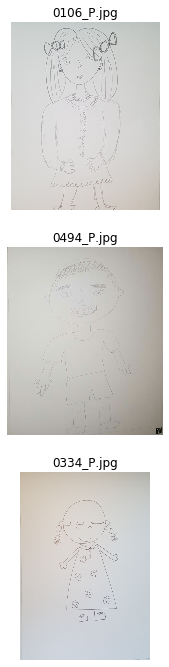

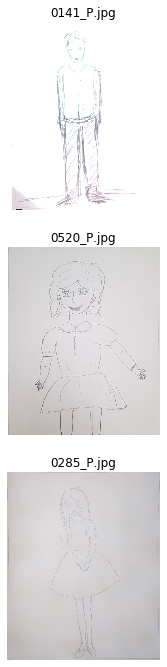

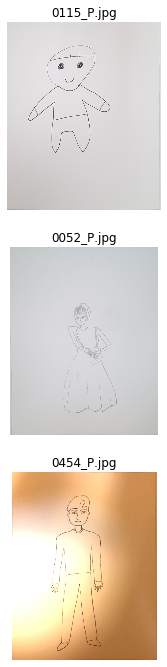

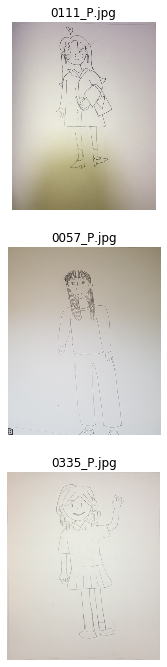

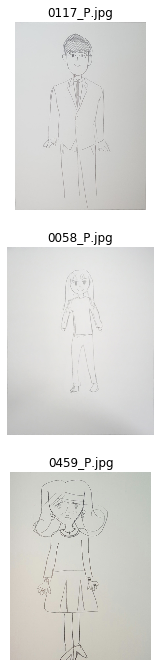

In [123]:
for i in range(len(df_train)):
    tmp_imgs = df_train[i]['data'][100:103]
    plt.figure(figsize=(12,20))
    for num, f_name in enumerate(tmp_imgs):
        img = PIL.Image.open(os.path.join(IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')

In [124]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train = []
X_val = []

for i, data in enumerate(feature):
    df_train[i][data] = df_train[i][data].astype('str')
#     df_train[i][data] = to_categorical(df_train[i][data], 2)
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]

    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])

    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print(df_test[i].shape)
    print("="*20)

문-격자무늬 창
(165, 2)
(42, 2)
(207, 2)
(90, 1)
위치-집-아래
(165, 2)
(42, 2)
(207, 2)
(90, 1)
위치-집-정중앙
(165, 2)
(42, 2)
(207, 2)
(90, 1)
지면선-벽 밑면 있지만 지면 없음
(165, 2)
(42, 2)
(207, 2)
(90, 1)
지붕-그물무늬 음영
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-격자무늬
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-많다
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-창문을 가린 커튼
(165, 2)
(42, 2)
(207, 2)
(90, 1)
크기-사람-작다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-정중앙
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-오른쪽
(164, 2)
(41, 2)
(205, 2)
(89, 1)
음영-사람-내부의 진한 음영
(164, 2)
(41, 2)
(205, 2)
(89, 1)
코-작다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
머리카락-윤곽선(검게 표현되지 않은 긴 머리)
(164, 2)
(41, 2)
(205, 2)
(89, 1)
팔-길다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
손-원모양 손, 주먹쥔 손
(164, 2)
(41, 2)
(205, 2)
(89, 1)
다리-넓게 벌림
(164, 2)
(41, 2)
(205, 2)
(89, 1)
다리-앉아있음
(164, 2)
(41, 2)
(205, 2)
(89, 1)
발-발가락 그림
(164, 2)
(41, 2)
(205, 2)
(89, 1)


In [125]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [126]:
epochs = 20
batch_size = 30
img_size = (224, 224)
# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False,
    rotation_range = 3,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(feature):
    nb_train_samples.append(len(X_train[i]))
    nb_validation_samples.append(len(X_val[i]))
    nb_test_samples.append(len(df_test[i]))
    
    
    # Make Generator
    train_generator.append(train_datagen.flow_from_dataframe(
        dataframe=X_train[i], 
        directory=IMG_PATH,
        x_col = 'data',
        y_col = feature[i],
        target_size = img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        seed=42
    ))

    validation_generator.append(val_datagen.flow_from_dataframe(
        dataframe=X_val[i], 
        directory=IMG_PATH,
        x_col='data',
        y_col=feature[i],
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    ))

    test_generator.append(test_datagen.flow_from_dataframe(
        dataframe=df_test[i],
        directory=IMG_PATH,
        x_col='data',
        y_col=None,
        target_size=img_size,
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        shuffle=False
    ))

Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 v

#이미지 생성 테스트 코드

img = load_img(IMAGE_PATH + 'house/0001_H.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

for batch in train_datagen.flow(x, batch_size=1, save_to_dir=IMAGE_PATH + 'house/preview', save_prefix='tri', save_format='png'):
    i += 1
    if i > 10: 
        break

In [127]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [128]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
model = MakeMobileModel()
model.summary()

C:\Users\AFFINITY\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d_62  (None, 1024)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [117]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = []

for i in range(len(feature)):
    model = MakeMobileModel()
    filepath = feature[i] + "_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5"
    
    ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

    callbackList = [ckpt]

    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = get_steps(nb_train_samples[i], batch_size),
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

Epoch 1/20
5/6 [========================>.....] - ETA: 4s - loss: 0.6902 - acc: 0.600 - ETA: 2s - loss: 0.6399 - acc: 0.711 - ETA: 2s - loss: 0.5151 - acc: 0.786 - ETA: 1s - loss: 0.5001 - acc: 0.800 - ETA: 0s - loss: 0.4182 - acc: 0.8370
Epoch 00001: val_loss improved from inf to 5.01977, saving model to 문-격자무늬 창_mobile_model_0.02_5.0198.h5
6/6 [==============================] - 6s 970ms/step - loss: 0.3724 - acc: 0.8606 - val_loss: 5.0198 - val_acc: 0.0238
Epoch 2/20
5/6 [========================>.....] - ETA: 1s - loss: 0.2055 - acc: 0.933 - ETA: 1s - loss: 0.1084 - acc: 0.966 - ETA: 1s - loss: 0.1199 - acc: 0.966 - ETA: 0s - loss: 0.0914 - acc: 0.971 - ETA: 0s - loss: 0.0787 - acc: 0.9778
Epoch 00002: val_loss improved from 5.01977 to 0.07762, saving model to 문-격자무늬 창_mobile_model_0.98_0.0776.h5
6/6 [==============================] - 5s 781ms/step - loss: 0.0668 - acc: 0.9818 - val_loss: 0.0776 - val_acc: 0.9762
Epoch 3/20
5/6 [========================>.....] - ETA: 1s - loss: 0.37

Epoch 20/20
5/6 [========================>.....] - ETA: 1s - loss: 1.5272e-05 - acc: 1.000 - ETA: 1s - loss: 1.4704e-05 - acc: 1.000 - ETA: 2s - loss: 1.0634e-05 - acc: 1.000 - ETA: 1s - loss: 1.2116e-05 - acc: 1.000 - ETA: 0s - loss: 1.3795e-05 - acc: 1.0000
Epoch 00020: val_loss did not improve from 0.07762
6/6 [==============================] - 7s 1s/step - loss: 1.4831e-05 - acc: 1.0000 - val_loss: 0.2250 - val_acc: 0.9762
Epoch 1/20
5/6 [========================>.....] - ETA: 9s - loss: 1.5968 - acc: 0.166 - ETA: 4s - loss: 1.3924 - acc: 0.366 - ETA: 3s - loss: 1.2743 - acc: 0.411 - ETA: 2s - loss: 1.1639 - acc: 0.475 - ETA: 0s - loss: 1.1474 - acc: 0.4889
Epoch 00001: val_loss improved from inf to 8.80124, saving model to 위치-집-아래_mobile_model_0.26_8.8012.h5
6/6 [==============================] - 8s 1s/step - loss: 1.0578 - acc: 0.5455 - val_loss: 8.8012 - val_acc: 0.2619
Epoch 2/20
5/6 [========================>.....] - ETA: 2s - loss: 0.5710 - acc: 0.866 - ETA: 1s - loss: 0.4298

5/6 [========================>.....] - ETA: 2s - loss: 0.0529 - acc: 0.966 - ETA: 2s - loss: 0.0266 - acc: 0.983 - ETA: 2s - loss: 0.0272 - acc: 0.977 - ETA: 1s - loss: 0.0777 - acc: 0.971 - ETA: 0s - loss: 0.0623 - acc: 0.9778
Epoch 00019: val_loss did not improve from 1.01665
6/6 [==============================] - 6s 929ms/step - loss: 0.0508 - acc: 0.9818 - val_loss: 1.4118 - val_acc: 0.8095
Epoch 20/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0011 - acc: 1.000 - ETA: 1s - loss: 0.2143 - acc: 0.977 - ETA: 1s - loss: 0.1548 - acc: 0.986 - ETA: 1s - loss: 0.1231 - acc: 0.981 - ETA: 0s - loss: 0.0992 - acc: 0.9852
Epoch 00020: val_loss did not improve from 1.01665
6/6 [==============================] - 6s 960ms/step - loss: 0.1580 - acc: 0.9636 - val_loss: 2.3852 - val_acc: 0.6905
Epoch 1/20
5/6 [========================>.....] - ETA: 5s - loss: 0.3295 - acc: 0.933 - ETA: 3s - loss: 0.4370 - acc: 0.822 - ETA: 2s - loss: 0.5012 - acc: 0.826 - ETA: 1s - loss: 0.4360 - acc

5/6 [========================>.....] - ETA: 2s - loss: 6.5984e-06 - acc: 1.000 - ETA: 2s - loss: 4.5460e-06 - acc: 1.000 - ETA: 1s - loss: 5.2733e-05 - acc: 1.000 - ETA: 1s - loss: 6.2792e-05 - acc: 1.000 - ETA: 0s - loss: 8.4858e-05 - acc: 1.0000
Epoch 00018: val_loss did not improve from 0.31360
6/6 [==============================] - 6s 968ms/step - loss: 7.7547e-05 - acc: 1.0000 - val_loss: 0.4016 - val_acc: 0.9524
Epoch 19/20
5/6 [========================>.....] - ETA: 1s - loss: 4.9273e-07 - acc: 1.000 - ETA: 1s - loss: 1.8271e-05 - acc: 1.000 - ETA: 1s - loss: 2.9367e-05 - acc: 1.000 - ETA: 1s - loss: 2.6642e-05 - acc: 1.000 - ETA: 0s - loss: 3.2458e-05 - acc: 1.0000
Epoch 00019: val_loss did not improve from 0.31360
6/6 [==============================] - 6s 944ms/step - loss: 4.7514e-05 - acc: 1.0000 - val_loss: 0.4071 - val_acc: 0.9524
Epoch 20/20
5/6 [========================>.....] - ETA: 2s - loss: 2.8284e-05 - acc: 1.000 - ETA: 2s - loss: 2.3385e-05 - acc: 1.000 - ETA: 1s -

Epoch 00017: val_loss did not improve from 1.29710
6/6 [==============================] - 6s 949ms/step - loss: 0.1667 - acc: 0.9697 - val_loss: 5.1393 - val_acc: 0.6667
Epoch 18/20
5/6 [========================>.....] - ETA: 2s - loss: 0.3284 - acc: 0.866 - ETA: 2s - loss: 0.1672 - acc: 0.933 - ETA: 1s - loss: 0.1192 - acc: 0.946 - ETA: 1s - loss: 0.0900 - acc: 0.961 - ETA: 0s - loss: 0.0751 - acc: 0.9704
Epoch 00018: val_loss did not improve from 1.29710
6/6 [==============================] - 5s 902ms/step - loss: 0.0985 - acc: 0.9636 - val_loss: 3.2791 - val_acc: 0.6667
Epoch 19/20
5/6 [========================>.....] - ETA: 2s - loss: 5.9918e-04 - acc: 1.000 - ETA: 2s - loss: 0.0067 - acc: 1.0000    - ETA: 1s - loss: 0.0085 - acc: 1.000 - ETA: 1s - loss: 0.0129 - acc: 1.000 - ETA: 0s - loss: 0.0502 - acc: 0.9926
Epoch 00019: val_loss did not improve from 1.29710
6/6 [==============================] - 6s 935ms/step - loss: 0.0619 - acc: 0.9879 - val_loss: 4.4922 - val_acc: 0.5476
Ep

5/6 [========================>.....] - ETA: 2s - loss: 0.0101 - acc: 1.000 - ETA: 1s - loss: 0.0057 - acc: 1.000 - ETA: 1s - loss: 0.0042 - acc: 1.000 - ETA: 1s - loss: 0.0033 - acc: 1.000 - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00017: val_loss did not improve from 0.47130
6/6 [==============================] - 6s 980ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 3.9567 - val_acc: 0.5000
Epoch 18/20
5/6 [========================>.....] - ETA: 2s - loss: 9.0652e-04 - acc: 1.000 - ETA: 2s - loss: 8.8551e-04 - acc: 1.000 - ETA: 1s - loss: 0.0011 - acc: 1.0000    - ETA: 1s - loss: 8.0641e-04 - acc: 1.000 - ETA: 0s - loss: 8.5261e-04 - acc: 1.0000
Epoch 00018: val_loss did not improve from 0.47130
6/6 [==============================] - 6s 937ms/step - loss: 7.3442e-04 - acc: 1.0000 - val_loss: 3.8015 - val_acc: 0.5238
Epoch 19/20
5/6 [========================>.....] - ETA: 2s - loss: 1.9303e-04 - acc: 1.000 - ETA: 2s - loss: 0.0304 - acc: 0.9833    - ETA: 2s - loss: 0.0205 - acc: 0.9

5/6 [========================>.....] - ETA: 2s - loss: 0.0016 - acc: 1.000 - ETA: 2s - loss: 0.0022 - acc: 1.000 - ETA: 1s - loss: 0.0046 - acc: 1.000 - ETA: 1s - loss: 0.0068 - acc: 1.000 - ETA: 0s - loss: 0.0105 - acc: 0.9926
Epoch 00016: val_loss did not improve from 1.54806
6/6 [==============================] - 6s 982ms/step - loss: 0.0116 - acc: 0.9939 - val_loss: 2.5970 - val_acc: 0.7381
Epoch 17/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0125 - acc: 1.000 - ETA: 2s - loss: 0.0065 - acc: 1.000 - ETA: 1s - loss: 0.0329 - acc: 1.000 - ETA: 1s - loss: 0.0252 - acc: 1.000 - ETA: 0s - loss: 0.0381 - acc: 0.9926
Epoch 00017: val_loss did not improve from 1.54806
6/6 [==============================] - 6s 999ms/step - loss: 0.0313 - acc: 0.9939 - val_loss: 2.3005 - val_acc: 0.6190
Epoch 18/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0024 - acc: 1.000 - ETA: 2s - loss: 0.0770 - acc: 0.966 - ETA: 2s - loss: 0.0971 - acc: 0.966 - ETA: 1s - loss: 0.0738 - ac

Epoch 00015: val_loss did not improve from 0.98265
6/6 [==============================] - 6s 1s/step - loss: 0.0039 - acc: 1.0000 - val_loss: 2.8931 - val_acc: 0.6667
Epoch 16/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0057 - acc: 1.000 - ETA: 2s - loss: 0.0031 - acc: 1.000 - ETA: 2s - loss: 0.0025 - acc: 1.000 - ETA: 1s - loss: 0.0020 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.0000
Epoch 00016: val_loss did not improve from 0.98265
6/6 [==============================] - 6s 970ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 2.8013 - val_acc: 0.6667
Epoch 17/20
5/6 [========================>.....] - ETA: 2s - loss: 6.4907e-05 - acc: 1.000 - ETA: 2s - loss: 7.9281e-04 - acc: 1.000 - ETA: 1s - loss: 0.0013 - acc: 1.0000    - ETA: 1s - loss: 9.7594e-04 - acc: 1.000 - ETA: 0s - loss: 7.9386e-04 - acc: 1.0000
Epoch 00017: val_loss did not improve from 0.98265
6/6 [==============================] - 6s 947ms/step - loss: 9.1593e-04 - acc: 1.0000 - val_loss: 2.7203 - val_a

5/6 [========================>.....] - ETA: 2s - loss: 3.4853e-04 - acc: 1.000 - ETA: 2s - loss: 2.0013e-04 - acc: 1.000 - ETA: 2s - loss: 3.4206e-04 - acc: 1.000 - ETA: 1s - loss: 2.8859e-04 - acc: 1.000 - ETA: 0s - loss: 3.1465e-04 - acc: 1.0000
Epoch 00014: val_loss did not improve from 0.24650
6/6 [==============================] - 6s 952ms/step - loss: 4.2785e-04 - acc: 1.0000 - val_loss: 0.8612 - val_acc: 0.7381
Epoch 15/20
5/6 [========================>.....] - ETA: 2s - loss: 4.3310e-04 - acc: 1.000 - ETA: 2s - loss: 0.0048 - acc: 1.0000    - ETA: 1s - loss: 0.0032 - acc: 1.000 - ETA: 1s - loss: 0.0025 - acc: 1.000 - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 00015: val_loss did not improve from 0.24650
6/6 [==============================] - 6s 921ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4191 - val_acc: 0.8333
Epoch 16/20
5/6 [========================>.....] - ETA: 2s - loss: 5.1032e-05 - acc: 1.000 - ETA: 2s - loss: 1.3939e-04 - acc: 1.000 - ETA: 2s - loss: 2.2248e-0

5/6 [========================>.....] - ETA: 2s - loss: 0.0018 - acc: 1.000 - ETA: 1s - loss: 0.0012 - acc: 1.000 - ETA: 1s - loss: 8.2300e-04 - acc: 1.000 - ETA: 1s - loss: 8.0371e-04 - acc: 1.000 - ETA: 0s - loss: 6.8232e-04 - acc: 1.0000
Epoch 00013: val_loss did not improve from 0.48332
6/6 [==============================] - 6s 1s/step - loss: 0.0083 - acc: 0.9939 - val_loss: 0.6363 - val_acc: 0.9268
Epoch 14/20
5/6 [========================>.....] - ETA: 2s - loss: 3.7207e-04 - acc: 1.000 - ETA: 2s - loss: 2.0756e-04 - acc: 1.000 - ETA: 2s - loss: 1.7226e-04 - acc: 1.000 - ETA: 1s - loss: 2.0065e-04 - acc: 1.000 - ETA: 0s - loss: 1.6292e-04 - acc: 1.0000
Epoch 00014: val_loss did not improve from 0.48332
6/6 [==============================] - 6s 946ms/step - loss: 1.3857e-04 - acc: 1.0000 - val_loss: 0.6434 - val_acc: 0.9268
Epoch 15/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0093 - acc: 1.000 - ETA: 3s - loss: 0.0047 - acc: 1.000 - ETA: 1s - loss: 0.0036 - acc: 1.

5/6 [========================>.....] - ETA: 2s - loss: 6.9926e-04 - acc: 1.000 - ETA: 3s - loss: 3.5388e-04 - acc: 1.000 - ETA: 1s - loss: 2.3975e-04 - acc: 1.000 - ETA: 1s - loss: 3.8757e-04 - acc: 1.000 - ETA: 0s - loss: 3.3174e-04 - acc: 1.0000
Epoch 00012: val_loss did not improve from 0.25489
6/6 [==============================] - 6s 990ms/step - loss: 2.8407e-04 - acc: 1.0000 - val_loss: 0.5094 - val_acc: 0.9512
Epoch 13/20
5/6 [========================>.....] - ETA: 2s - loss: 1.5834e-04 - acc: 1.000 - ETA: 1s - loss: 9.0639e-05 - acc: 1.000 - ETA: 1s - loss: 1.0874e-04 - acc: 1.000 - ETA: 1s - loss: 8.6279e-05 - acc: 1.000 - ETA: 0s - loss: 7.8425e-05 - acc: 1.0000
Epoch 00013: val_loss did not improve from 0.25489
6/6 [==============================] - 6s 962ms/step - loss: 1.0555e-04 - acc: 1.0000 - val_loss: 0.5209 - val_acc: 0.9512
Epoch 14/20
5/6 [========================>.....] - ETA: 2s - loss: 5.0783e-05 - acc: 1.000 - ETA: 1s - loss: 2.0022e-04 - acc: 1.000 - ETA: 1s -

5/6 [========================>.....] - ETA: 2s - loss: 0.0047 - acc: 1.000 - ETA: 2s - loss: 0.0154 - acc: 0.983 - ETA: 2s - loss: 0.0247 - acc: 0.977 - ETA: 1s - loss: 0.0293 - acc: 0.983 - ETA: 0s - loss: 0.0424 - acc: 0.9733
Epoch 00010: val_loss did not improve from 0.18583
6/6 [==============================] - 6s 925ms/step - loss: 0.0369 - acc: 0.9756 - val_loss: 0.4133 - val_acc: 0.9024
Epoch 11/20
5/6 [========================>.....] - ETA: 2s - loss: 8.9976e-04 - acc: 1.000 - ETA: 3s - loss: 0.0139 - acc: 1.0000    - ETA: 2s - loss: 0.0774 - acc: 0.988 - ETA: 1s - loss: 0.0588 - acc: 0.991 - ETA: 0s - loss: 0.0474 - acc: 0.9933
Epoch 00011: val_loss did not improve from 0.18583
6/6 [==============================] - 6s 988ms/step - loss: 0.0548 - acc: 0.9878 - val_loss: 0.3204 - val_acc: 0.8780
Epoch 12/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0040 - acc: 1.000 - ETA: 3s - loss: 0.0107 - acc: 1.000 - ETA: 2s - loss: 0.0072 - acc: 1.000 - ETA: 1s - loss: 0.0

5/6 [========================>.....] - ETA: 2s - loss: 6.1257e-04 - acc: 1.000 - ETA: 2s - loss: 9.2966e-04 - acc: 1.000 - ETA: 2s - loss: 0.0011 - acc: 1.0000    - ETA: 1s - loss: 0.0026 - acc: 1.000 - ETA: 0s - loss: 0.0236 - acc: 0.9933
Epoch 00009: val_loss did not improve from 0.36528
6/6 [==============================] - 6s 1s/step - loss: 0.0215 - acc: 0.9939 - val_loss: 0.5854 - val_acc: 0.8049
Epoch 10/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0029 - acc: 1.000 - ETA: 3s - loss: 0.0015 - acc: 1.000 - ETA: 1s - loss: 0.0010 - acc: 1.000 - ETA: 1s - loss: 7.6496e-04 - acc: 1.000 - ETA: 0s - loss: 6.1764e-04 - acc: 1.0000
Epoch 00010: val_loss improved from 0.36528 to 0.13547, saving model to 음영-사람-내부의 진한 음영_mobile_model_0.93_0.1355.h5
6/6 [==============================] - 7s 1s/step - loss: 7.8862e-04 - acc: 1.0000 - val_loss: 0.1355 - val_acc: 0.9268
Epoch 11/20
5/6 [========================>.....] - ETA: 2s - loss: 1.7154e-05 - acc: 1.000 - ETA: 2s - loss: 

Epoch 8/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0234 - acc: 1.000 - ETA: 1s - loss: 0.0120 - acc: 1.000 - ETA: 1s - loss: 0.0097 - acc: 1.000 - ETA: 1s - loss: 0.0082 - acc: 1.000 - ETA: 0s - loss: 0.0069 - acc: 1.0000
Epoch 00008: val_loss did not improve from 1.69185
6/6 [==============================] - 6s 997ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 2.4589 - val_acc: 0.8293
Epoch 9/20
5/6 [========================>.....] - ETA: 1s - loss: 1.2656e-04 - acc: 1.000 - ETA: 1s - loss: 0.0448 - acc: 0.9773    - ETA: 1s - loss: 0.0306 - acc: 0.986 - ETA: 1s - loss: 0.0254 - acc: 0.990 - ETA: 0s - loss: 0.0234 - acc: 0.9925
Epoch 00009: val_loss did not improve from 1.69185
6/6 [==============================] - 6s 937ms/step - loss: 0.0201 - acc: 0.9939 - val_loss: 1.9379 - val_acc: 0.7805
Epoch 10/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0461 - acc: 0.966 - ETA: 2s - loss: 0.0238 - acc: 0.983 - ETA: 2s - loss: 0.0171 - acc: 0.988 - ETA: 1s -

Epoch 7/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0049 - acc: 1.000 - ETA: 3s - loss: 0.0025 - acc: 1.000 - ETA: 2s - loss: 0.0409 - acc: 0.977 - ETA: 1s - loss: 0.0307 - acc: 0.983 - ETA: 0s - loss: 0.0246 - acc: 0.9851
Epoch 00007: val_loss improved from 2.94943 to 2.10834, saving model to 머리카락-윤곽선(검게 표현되지 않은 긴 머리)_mobile_model_0.44_2.1083.h5
6/6 [==============================] - 6s 1s/step - loss: 0.0208 - acc: 0.9878 - val_loss: 2.1083 - val_acc: 0.4390
Epoch 8/20
5/6 [========================>.....] - ETA: 1s - loss: 4.3238e-05 - acc: 1.000 - ETA: 1s - loss: 6.6233e-04 - acc: 1.000 - ETA: 1s - loss: 7.6448e-04 - acc: 1.000 - ETA: 1s - loss: 0.0173 - acc: 0.9904    - ETA: 0s - loss: 0.0141 - acc: 0.9925
Epoch 00008: val_loss did not improve from 2.10834
6/6 [==============================] - 6s 943ms/step - loss: 0.0120 - acc: 0.9939 - val_loss: 2.9866 - val_acc: 0.2683
Epoch 9/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0015 - acc: 1.000 - ETA: 2

5/6 [========================>.....] - ETA: 1s - loss: 0.0062 - acc: 1.000 - ETA: 1s - loss: 0.0033 - acc: 1.000 - ETA: 1s - loss: 0.0023 - acc: 1.000 - ETA: 1s - loss: 0.0018 - acc: 1.000 - ETA: 0s - loss: 0.0021 - acc: 1.0000
Epoch 00005: val_loss improved from 1.55195 to 0.18933, saving model to 팔-길다_mobile_model_0.93_0.1893.h5
6/6 [==============================] - 6s 991ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1893 - val_acc: 0.9268
Epoch 6/20
5/6 [========================>.....] - ETA: 2s - loss: 7.8247e-05 - acc: 1.000 - ETA: 2s - loss: 5.2187e-05 - acc: 1.000 - ETA: 1s - loss: 6.1235e-05 - acc: 1.000 - ETA: 1s - loss: 5.1763e-05 - acc: 1.000 - ETA: 0s - loss: 8.6534e-05 - acc: 1.0000
Epoch 00006: val_loss improved from 0.18933 to 0.15574, saving model to 팔-길다_mobile_model_0.98_0.1557.h5
6/6 [==============================] - 6s 999ms/step - loss: 7.9656e-05 - acc: 1.0000 - val_loss: 0.1557 - val_acc: 0.9756
Epoch 7/20
5/6 [========================>.....] - ETA: 2s - l

6/6 [==============================] - 6s 979ms/step - loss: 0.1034 - acc: 0.9512 - val_loss: 2.8085 - val_acc: 0.8293
Epoch 4/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0192 - acc: 1.000 - ETA: 2s - loss: 0.1062 - acc: 0.983 - ETA: 1s - loss: 0.0734 - acc: 0.986 - ETA: 1s - loss: 0.0844 - acc: 0.971 - ETA: 0s - loss: 0.0817 - acc: 0.9701
Epoch 00004: val_loss did not improve from 0.56983
6/6 [==============================] - 6s 995ms/step - loss: 0.0697 - acc: 0.9756 - val_loss: 2.8085 - val_acc: 0.8293
Epoch 5/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0019 - acc: 1.000 - ETA: 2s - loss: 0.0041 - acc: 1.000 - ETA: 2s - loss: 0.0126 - acc: 1.000 - ETA: 1s - loss: 0.0099 - acc: 1.000 - ETA: 0s - loss: 0.0158 - acc: 0.9925
Epoch 00005: val_loss did not improve from 0.56983
6/6 [==============================] - 6s 961ms/step - loss: 0.0138 - acc: 0.9939 - val_loss: 2.8085 - val_acc: 0.8293
Epoch 6/20
5/6 [========================>.....] - ETA: 2s - los

5/6 [========================>.....] - ETA: 1s - loss: 0.0298 - acc: 1.000 - ETA: 1s - loss: 0.0178 - acc: 1.000 - ETA: 1s - loss: 0.0213 - acc: 1.000 - ETA: 1s - loss: 0.0172 - acc: 1.000 - ETA: 0s - loss: 0.0140 - acc: 1.0000
Epoch 00003: val_loss did not improve from 7.76316
6/6 [==============================] - 6s 923ms/step - loss: 0.0249 - acc: 0.9939 - val_loss: 11.0643 - val_acc: 0.0244
Epoch 4/20
5/6 [========================>.....] - ETA: 2s - loss: 0.0011 - acc: 1.000 - ETA: 2s - loss: 0.0042 - acc: 1.000 - ETA: 2s - loss: 0.0033 - acc: 1.000 - ETA: 1s - loss: 0.0025 - acc: 1.000 - ETA: 0s - loss: 0.0020 - acc: 1.0000
Epoch 00004: val_loss did not improve from 7.76316
6/6 [==============================] - 6s 966ms/step - loss: 0.0088 - acc: 0.9939 - val_loss: 9.9910 - val_acc: 0.0244
Epoch 5/20
5/6 [========================>.....] - ETA: 1s - loss: 0.1142 - acc: 0.928 - ETA: 1s - loss: 0.0588 - acc: 0.977 - ETA: 1s - loss: 0.0432 - acc: 0.986 - ETA: 1s - loss: 0.0346 - acc

Epoch 1/20
5/6 [========================>.....] - ETA: 7s - loss: 0.5530 - acc: 0.766 - ETA: 3s - loss: 0.4272 - acc: 0.833 - ETA: 2s - loss: 0.3758 - acc: 0.877 - ETA: 1s - loss: 0.2879 - acc: 0.908 - ETA: 0s - loss: 0.2358 - acc: 0.9179
Epoch 00001: val_loss improved from inf to 15.68046, saving model to 다리-앉아있음_mobile_model_0.02_15.6805.h5
6/6 [==============================] - 6s 995ms/step - loss: 0.2514 - acc: 0.9146 - val_loss: 15.6805 - val_acc: 0.0244
Epoch 2/20
5/6 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 1.000 - ETA: 1s - loss: 0.1006 - acc: 0.983 - ETA: 1s - loss: 0.1120 - acc: 0.966 - ETA: 0s - loss: 0.1127 - acc: 0.961 - ETA: 0s - loss: 0.0923 - acc: 0.9701
Epoch 00002: val_loss improved from 15.68046 to 3.48196, saving model to 다리-앉아있음_mobile_model_0.39_3.4820.h5
6/6 [==============================] - 5s 848ms/step - loss: 0.0835 - acc: 0.9695 - val_loss: 3.4820 - val_acc: 0.3902
Epoch 3/20
5/6 [========================>.....] - ETA: 1s - loss: 0.

Epoch 00019: val_loss did not improve from 0.75590
6/6 [==============================] - 5s 834ms/step - loss: 2.7221e-05 - acc: 1.0000 - val_loss: 4.7869 - val_acc: 0.3659
Epoch 20/20
5/6 [========================>.....] - ETA: 1s - loss: 1.9908e-06 - acc: 1.000 - ETA: 2s - loss: 1.5001e-06 - acc: 1.000 - ETA: 1s - loss: 7.4747e-06 - acc: 1.000 - ETA: 1s - loss: 8.5676e-06 - acc: 1.000 - ETA: 0s - loss: 7.3683e-06 - acc: 1.0000
Epoch 00020: val_loss did not improve from 0.75590
6/6 [==============================] - 5s 869ms/step - loss: 7.6107e-06 - acc: 1.0000 - val_loss: 4.0154 - val_acc: 0.4634
Epoch 1/20
5/6 [========================>.....] - ETA: 6s - loss: 0.5634 - acc: 0.666 - ETA: 3s - loss: 0.5127 - acc: 0.766 - ETA: 2s - loss: 0.4196 - acc: 0.797 - ETA: 1s - loss: 0.3322 - acc: 0.855 - ETA: 0s - loss: 0.2758 - acc: 0.8881
Epoch 00001: val_loss improved from inf to 0.16280, saving model to 발-발가락 그림_mobile_model_0.95_0.1628.h5
6/6 [==============================] - 6s 1s/ste

Epoch 00018: val_loss did not improve from 0.07490
6/6 [==============================] - 5s 822ms/step - loss: 4.7196e-05 - acc: 1.0000 - val_loss: 0.3355 - val_acc: 0.9512
Epoch 19/20
5/6 [========================>.....] - ETA: 1s - loss: 2.0425e-06 - acc: 1.000 - ETA: 1s - loss: 1.7557e-06 - acc: 1.000 - ETA: 1s - loss: 4.1144e-06 - acc: 1.000 - ETA: 1s - loss: 5.8218e-06 - acc: 1.000 - ETA: 0s - loss: 5.9021e-06 - acc: 1.0000
Epoch 00019: val_loss did not improve from 0.07490
6/6 [==============================] - 5s 887ms/step - loss: 6.6353e-06 - acc: 1.0000 - val_loss: 0.3345 - val_acc: 0.9512
Epoch 20/20
5/6 [========================>.....] - ETA: 1s - loss: 3.2505e-06 - acc: 1.000 - ETA: 1s - loss: 7.2069e-06 - acc: 1.000 - ETA: 1s - loss: 9.3432e-06 - acc: 1.000 - ETA: 1s - loss: 5.5899e-04 - acc: 1.000 - ETA: 0s - loss: 4.4878e-04 - acc: 1.0000
Epoch 00020: val_loss did not improve from 0.07490
6/6 [==============================] - 5s 825ms/step - loss: 3.7933e-04 - acc: 1.

문-격자무늬 창


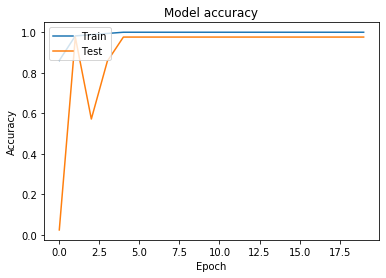

위치-집-아래


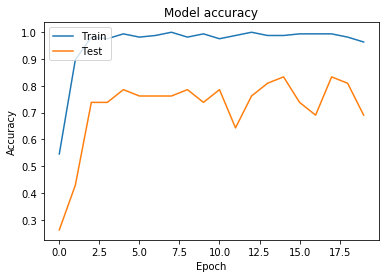

위치-집-정중앙


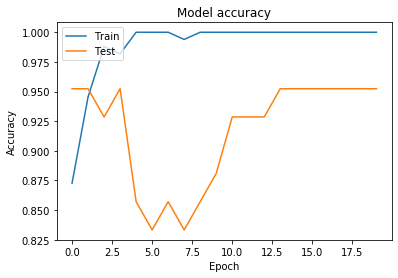

지면선-벽 밑면 있지만 지면 없음


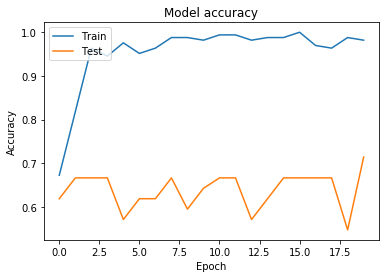

지붕-그물무늬 음영


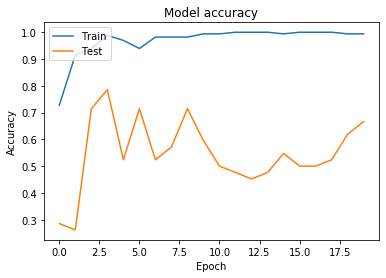

창문-격자무늬


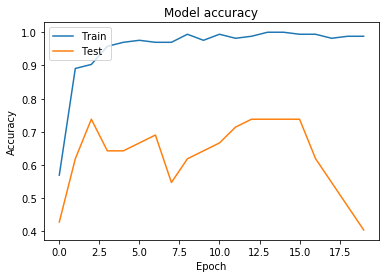

창문-많다


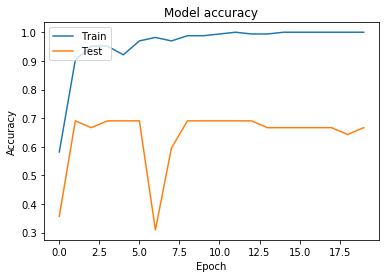

창문-창문을 가린 커튼


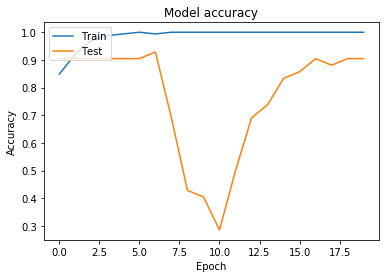

크기-사람-작다


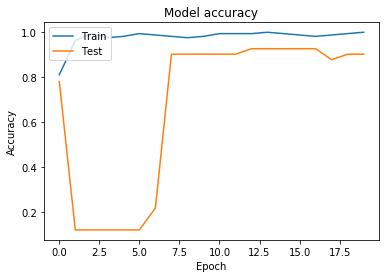

위치-사람-정중앙


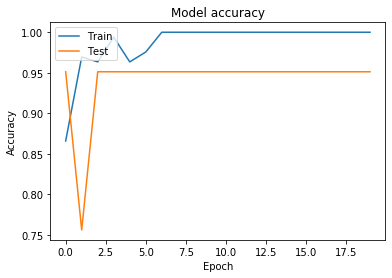

위치-사람-오른쪽


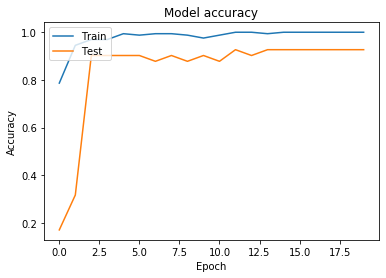

음영-사람-내부의 진한 음영


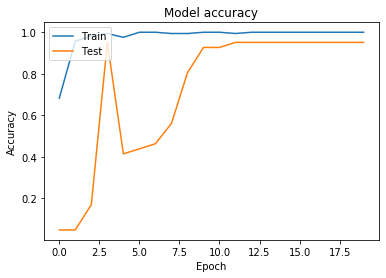

코-작다


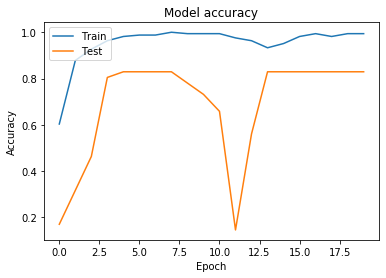

머리카락-윤곽선(검게 표현되지 않은 긴 머리)


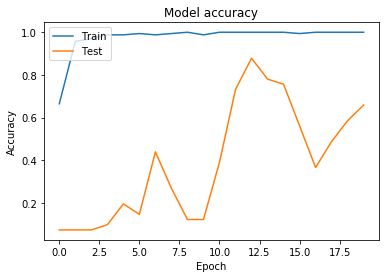

팔-길다


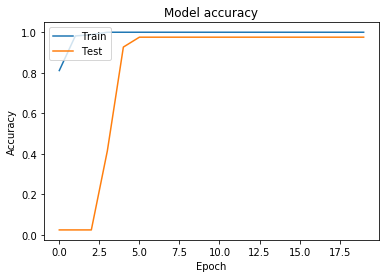

손-원모양 손, 주먹쥔 손


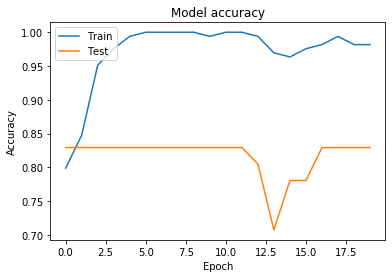

다리-넓게 벌림


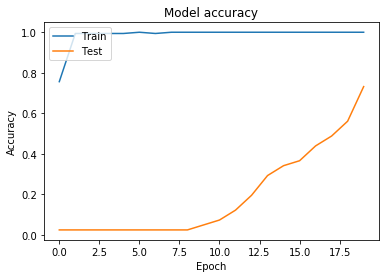

다리-앉아있음


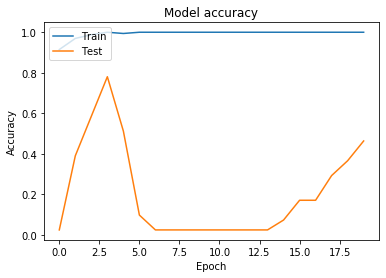

발-발가락 그림


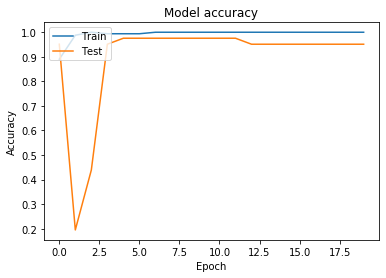

In [132]:
for i in range(len(feature)):
    print(feature[i])
    plt.plot(history[i].history['acc'])
    plt.plot(history[i].history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

문-격자무늬 창


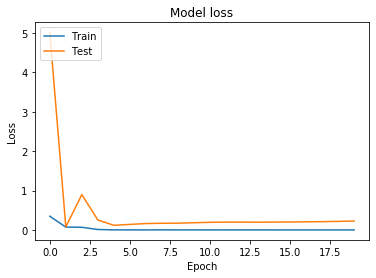

위치-집-아래


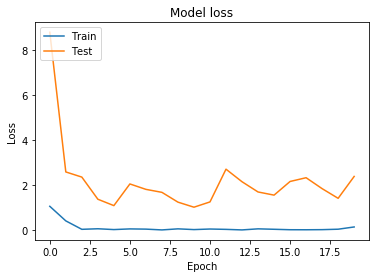

위치-집-정중앙


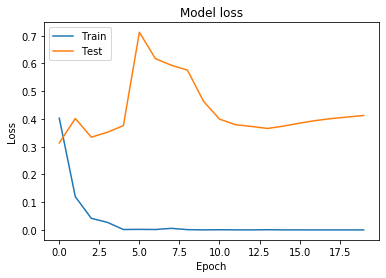

지면선-벽 밑면 있지만 지면 없음


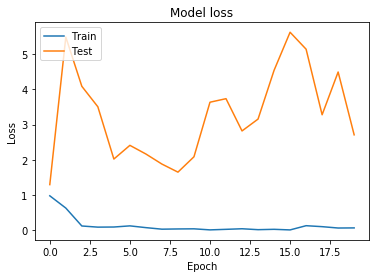

지붕-그물무늬 음영


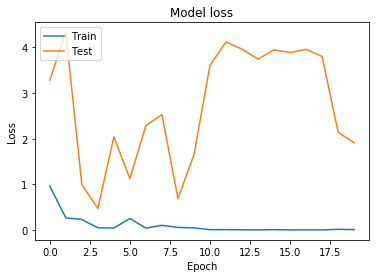

창문-격자무늬


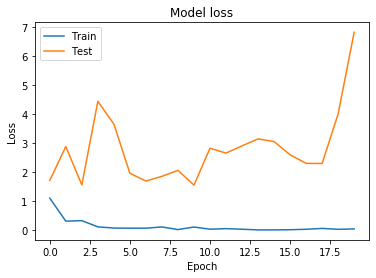

창문-많다


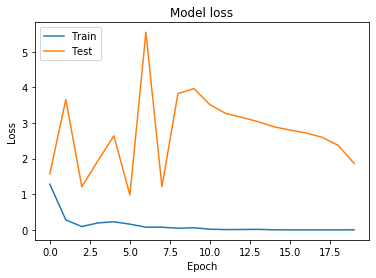

창문-창문을 가린 커튼


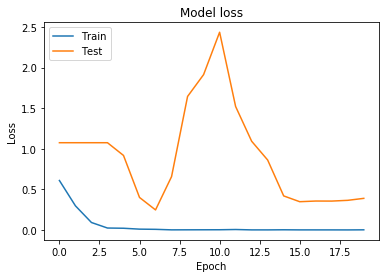

크기-사람-작다


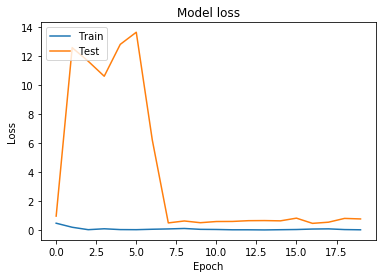

위치-사람-정중앙


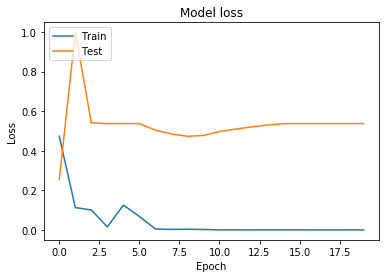

위치-사람-오른쪽


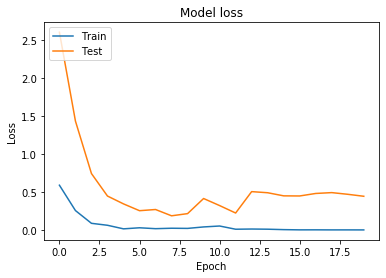

음영-사람-내부의 진한 음영


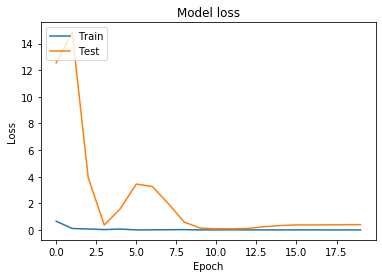

코-작다


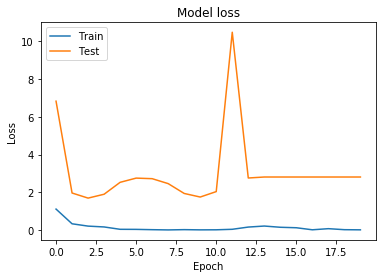

머리카락-윤곽선(검게 표현되지 않은 긴 머리)


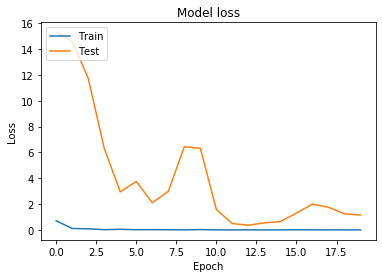

팔-길다


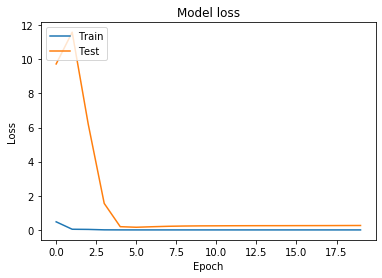

손-원모양 손, 주먹쥔 손


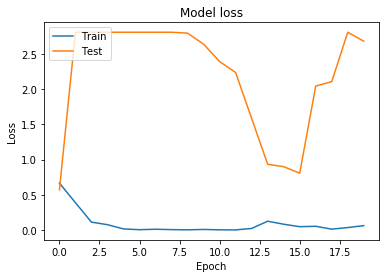

다리-넓게 벌림


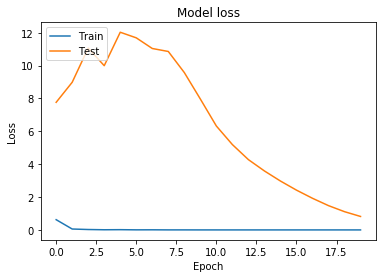

다리-앉아있음


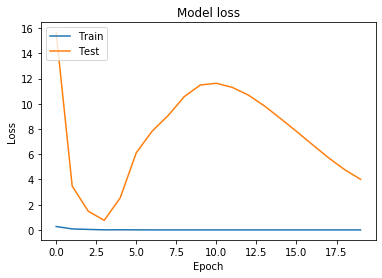

발-발가락 그림


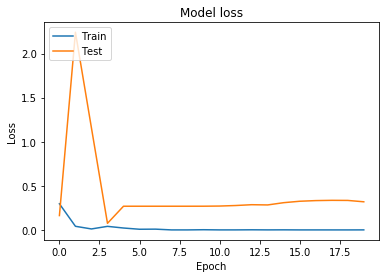

In [133]:
# Plot training & validation loss values
for i  in range(len(feature)):
    print(feature[i])
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [134]:
model_list = []
for num, h in enumerate(feature):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

['h_문-격자무늬 창_submission.xlsx', '문-격자무늬 창_mobile_model_0.02_5.0198.h5', '문-격자무늬 창_mobile_model_0.98_0.0776.h5']
['h_위치-집-아래_submission.xlsx', '위치-집-아래_mobile_model_0.26_8.8012.h5', '위치-집-아래_mobile_model_0.43_2.5851.h5', '위치-집-아래_mobile_model_0.74_1.0166.h5', '위치-집-아래_mobile_model_0.74_1.3709.h5', '위치-집-아래_mobile_model_0.74_2.3563.h5', '위치-집-아래_mobile_model_0.79_1.0867.h5']
['h_위치-집-정중앙_submission.xlsx', '위치-집-정중앙_mobile_model_0.95_0.3136.h5']
['h_지면선-벽 밑면 있지만 지면 없음_submission.xlsx', '지면선-벽 밑면 있지만 지면 없음_mobile_model_0.62_1.2971.h5']
['h_지붕-그물무늬 음영_submission.xlsx', 'h_지붕-그물무늬 음영_submission2.xlsx', '지붕-그물무늬 음영_mobile_model_0.29_3.2820.h5', '지붕-그물무늬 음영_mobile_model_0.71_0.9953.h5', '지붕-그물무늬 음영_mobile_model_0.79_0.4713.h5']
['h_창문-격자무늬_submission.xlsx', '창문-격자무늬_mobile_model_0.43_1.7114.h5', '창문-격자무늬_mobile_model_0.64_1.5481.h5', '창문-격자무늬_mobile_model_0.74_1.5568.h5']
['h_창문-많다_submission.xlsx', '창문-많다_mobile_model_0.36_1.5730.h5', '창문-많다_mobile_model_0.67_1.2107.h5', '창문-많다_mobile_model_0.

In [135]:
prediction = []
for i, h in enumerate(feature):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose=1
        ))


3/3 [==============================] - ETA:  - ETA:  - 1s 441ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 455ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 499ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 486ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 484ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 483ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 481ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 471ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 470ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 477ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 491ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 473ms/step

3/3 [==============================] - ETA:  - ETA:  - 1s 481ms/step

3/3 [==============================] - ETA:  - ETA:  - 2s 506ms/step

3/3 [==============

In [136]:
for i, h in enumerate(feature):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    # Generator class dictionary mapping
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    submission[h + "_class"] = predictions
    print(submission.head(10))
    submission.to_excel("h_" + h + "_submission.xlsx", index=False)
    print('='*20)

90
df_test (90, 1)
prediction (90, 2)
   Unnamed: 0        data  문-격자무늬 창 문-격자무늬 창_class
0          60  0104_H.jpg         0              0
1         271  0498_H.jpg         0              0
2          22  0038_H.jpg         0              0
3         102  0196_H.jpg         0              0
4         109  0203_H.jpg         0              0
5          74  0123_H.jpg         0              0
6          84  0156_H.jpg         0              0
7          45  0076_H.jpg         0              0
8         246  0464_H.jpg         0              0
9          62  0107_H.jpg         0              0
90
df_test (90, 1)
prediction (90, 2)
   Unnamed: 0        data  위치-집-아래 위치-집-아래_class
0         233  0444_H.jpg        0             0
1          14  0023_H.jpg        0             0
2         152  0287_H.jpg        1             0
3          43  0073_H.jpg        1             0
4          28  0046_H.jpg        1             0
5          94  0184_H.jpg        1             0
6          40  0068_

9         228  0441_P.jpg     0          0
89
df_test (89, 1)
prediction (89, 2)
   Unnamed: 0        data  머리카락-윤곽선(검게 표현되지 않은 긴 머리)  \
0         265  0498_P.jpg                          0   
1         143  0263_P.jpg                          0   
2          21  0039_P.jpg                          0   
3          79  0135_P.jpg                          0   
4         175  0336_P.jpg                          0   
5          44  0074_P.jpg                          1   
6           3  0004_P.jpg                          0   
7          15  0029_P.jpg                          0   
8          64  0102_P.jpg                          1   
9         267  0500_P.jpg                          0   

  머리카락-윤곽선(검게 표현되지 않은 긴 머리)_class  
0                               0  
1                               0  
2                               0  
3                               1  
4                               0  
5                               0  
6                               0  
7             

In [137]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [138]:
# def micro_f1(y_true, y_pred):
#     return f1_score(y_true, y_pred, average='micro')

for h in feature:
    submission = pd.read_excel("h_"+h+"_submission.xlsx")
    print(h , " : " , micro_f1(submission[h],submission[h+ '_class']))

문-격자무늬 창  :  0.9666666666666667
위치-집-아래  :  0.7777777777777778
위치-집-정중앙  :  0.9444444444444444
지면선-벽 밑면 있지만 지면 없음  :  0.6555555555555556
지붕-그물무늬 음영  :  0.8444444444444444
창문-격자무늬  :  0.5777777777777777
창문-많다  :  0.6777777777777778
창문-창문을 가린 커튼  :  0.8888888888888888
크기-사람-작다  :  0.9325842696629213
위치-사람-정중앙  :  0.9213483146067416
위치-사람-오른쪽  :  0.9101123595505618
음영-사람-내부의 진한 음영  :  0.9438202247191011
코-작다  :  0.5168539325842697
머리카락-윤곽선(검게 표현되지 않은 긴 머리)  :  0.8089887640449437
팔-길다  :  0.9887640449438202
손-원모양 손, 주먹쥔 손  :  0.8539325842696629
다리-넓게 벌림  :  0.5168539325842697
다리-앉아있음  :  0.8202247191011236
발-발가락 그림  :  0.9775280898876404


In [ ]:
# h = feature
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']
   
    for i in range(len(excel)):
        #print(type(actual[i]), type(predicted[i]))
        #print(actual[i], predicted[i])
        if(actual[i] == predicted[i]):
            if(actual[i] == 1):
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if(actual[i] == 1):
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP
    
    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)
    
    return TP,FP,FN,TN,precision,neg_pred, sensi, spec, Accu     

In [ ]:
bestfeature = ['위치-집-아래',
              '지면선-벽 밑면 있지만 지면 없음',
              '지붕-그물무늬 음영']

In [11]:
for h in bestfeature:
    excel = pd.read_excel("./bestfeature/h_"+h+"_submission.xlsx")
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('False Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('negatuve_predictive_value : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print("f1 score : " , micro_f1(excel[h],excel[h+ '_class']))
    print('='*40)

위치-집-아래 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  15
False Positive(FP) :  16
False Negative(FN) :  75
True Negative(TN) :  74
precision :  0.4838709677419355
negatuve_predictive_value :  0.4966442953020134
sensitivity :  0.16666666666666666
specificity :  0.8222222222222222
Accuracy :  0.49444444444444446
f1 score :  0.7333333333333333
지면선-벽 밑면 있지만 지면 없음 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  49
False Positive(FP) :  18
False Negative(FN) :  41
True Negative(TN) :  72
precision :  0.7313432835820896
negatuve_predictive_value :  0.6371681415929203
sensitivity :  0.5444444444444444
specificity :  0.8
Accuracy :  0.6722222222222223
f1 score :  0.6888888888888889
지붕-그물무늬 음영 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  17
False Positive(FP) :  6
False Negative(FN) :  73
True Negative(TN) :  84
precision :  0.7391304347826086
negatuve_predictive_value :  0.535031847133758
sensitivity :  0.18888888888888888
s